## importing data


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pickle
file_path = '/content/drive/My Drive/Colab Notebooks/textAsData/splitData.pickle'
with open(file_path, 'rb') as f:
    texts_train = pickle.load(f)
    texts_val = pickle.load(f)
    texts_test = pickle.load(f)
    labels_train = pickle.load(f)
    labels_val = pickle.load(f)
    labels_test = pickle.load(f)

all_texts  = texts_train  + texts_val  + texts_test
all_labels = labels_train + labels_val + labels_test
# check the ratio of each dataset
total = len(texts_train) + len(texts_val) + len(texts_test)
len(texts_train)/total, len(texts_val)/total, len(texts_test)/total

(0.5997757847533632, 0.20011210762331838, 0.20011210762331838)

In [3]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# (A) Using Context Vectors for Classification

In [4]:
import torch
from transformers import pipeline
pipe = pipeline('feature-extraction',model='roberta-base',truncation=True)# Truncation is needed to handle longer documents over 512 tokens

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from tqdm import tqdm
# create the context vector of [CLS] token of training set.

starts_train = []
for i in tqdm(range(len(texts_train))):
  context_vector = pipe(texts_train[i],return_tensors='pt')
  starts_train.append(context_vector[0,0,:])
starts_train = torch.stack(starts_train)
starts_train.shape

100%|██████████| 1070/1070 [33:00<00:00,  1.85s/it]


torch.Size([1070, 768])

In [ ]:
# create the context vector of [CLS] token of validation set.

starts_val = []
for i in tqdm(range(len(texts_val))):
  context_vector = pipe(texts_val[i],return_tensors='pt')
  starts_val.append(context_vector[0,0,:])
starts_val = torch.stack(starts_val)
starts_val.shape

100%|██████████| 357/357 [09:58<00:00,  1.68s/it]


torch.Size([357, 768])

### Logistic Regression

In [4]:
# Show classifier performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def showPerformance(labels_true, labels_predicted):
    print(f'accuracy ={accuracy_score(labels_true, labels_predicted):.3f}')
    print(f'precision={precision_score(labels_true, labels_predicted, average="macro"):.3f}')
    print(f'recall   ={recall_score(labels_true, labels_predicted, average="macro"):.3f}') 
    print(f'f1       ={f1_score(labels_true, labels_predicted, average="macro"):.3f}')
    return ;


In [ ]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression
clf = LogisticRegression(random_state=42,max_iter=1000).fit(starts_train.detach().numpy(), labels_train)
labels_predicted = clf.predict(starts_val.detach().numpy())


showPerformance(labels_val, labels_predicted)

accuracy =0.524
precision=0.476
recall   =0.517
f1       =0.485


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# (b)

### Create Dataset for Training and Validation

In [3]:
# correspond labels(songer names) with integers
label2id = {"Beyonce Knowles":0,
            "Michael Jackson":1,
            "Lady Gaga":2,
            "Taylor Swift":3,
            "Ariana Grande":4,
            "Selena Gomez":5,
            "Eminem":6,
            "Jennifer Lopez":7,
            "Dua Lipa":8,
            "XXXTentacion":9}
id2label = {id:label for label,id in label2id.items()}

In [6]:
labels_train_int = [label2id[l] for l in labels_train]
labels_val_int = [label2id[l] for l in labels_val]

In [7]:
from transformers import AutoTokenizer
from datasets import Dataset

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def createDataset(texts, labels_int):
    encoded_texts = []
    for t in texts:
        encoded_texts.append(tokenizer.encode(t,truncation=True))#,max_length=128))### max_length need to be changed
    
    dataset = Dataset.from_dict({
        "input_ids":encoded_texts,
        "labels": labels_int
    })
    return dataset

train_dataset = createDataset(texts_train, labels_train_int)
validation_dataset = createDataset(texts_val, labels_val_int)


In [6]:
# check Dataset
print(train_dataset)
train_taset[0]["input_ids"][:10]

In [9]:
from transformers import set_seed, AutoModelForSequenceClassification

set_seed(42)

model = AutoModelForSequenceClassification.from_pretrained('roberta-base',id2label=id2label)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

### Training with Designated Parameters

In [10]:
# parameters
learning_rate = 1e-4
epochs = 1
batch_size = 16
# weight_decay = None

In [11]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="singers_model", # HuggingFace wants a name for your model
    evaluation_strategy="epoch", # How often we want to evaluate the model
    learning_rate=learning_rate, # Hyperparameter
    per_device_train_batch_size=batch_size, # Hyperparameter
    per_device_eval_batch_size=batch_size, # Hyperparameter
    num_train_epochs=epochs # Hyperparameter
    # weight_decay=weight_decay, # Hyperparameter
)

In [12]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


trainer = Trainer(
    model=model, # The model you want to train
    args=training_args, # The various training arguments set up above
    train_dataset=train_dataset, # The data to use to update the weights
    eval_dataset=validation_dataset, # The data to use 
    tokenizer=tokenizer, # The tokenizer used on the data
    data_collator=data_collator, # A data collator that does clever things moving data around
)

In [13]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1070
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 67
  Number of trainable parameters = 124653322
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,No log,2.266755


***** Running Evaluation *****
  Num examples = 357
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=67, training_loss=2.2934135323140157, metrics={'train_runtime': 129.0258, 'train_samples_per_second': 8.293, 'train_steps_per_second': 0.519, 'total_flos': 281549051105280.0, 'train_loss': 2.2934135323140157, 'epoch': 1.0})

In [14]:
predictions, label_ids, metrics = trainer.predict(validation_dataset)

***** Running Prediction *****
  Num examples = 357
  Batch size = 16


In [15]:
metrics

{'test_loss': 2.2667553424835205,
 'test_runtime': 13.34,
 'test_samples_per_second': 26.762,
 'test_steps_per_second': 1.724}

In [16]:
print(f"{type(predictions)=}")
print(f"{predictions.shape=}")

type(predictions)=<class 'numpy.ndarray'>
predictions.shape=(357, 10)


In [3]:
# Show classifier performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def showPerformance(labels_true, labels_predicted):
    print(f'accuracy ={accuracy_score(labels_true, labels_predicted):.3f}')
    print(f'precision={precision_score(labels_true, labels_predicted, average="macro"):.3f}')
    print(f'recall   ={recall_score(labels_true, labels_predicted, average="macro"):.3f}') 
    print(f'f1       ={f1_score(labels_true, labels_predicted, average="macro"):.3f}')
    return ;

In [18]:
labels_predicted = predictions.argmax(axis=1)
showPerformance(label_ids, labels_predicted)

accuracy =0.143
precision=0.030
recall   =0.164
f1       =0.051


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Q5 (c) Parameter Tuning is conducted in a file "q5_param.ipynb"

# Q6 Evaluation with TestData

In [16]:
#import data again
with open("splitData.pickle", 'rb') as f:
    texts_train = pickle.load(f)
    texts_val = pickle.load(f)
    texts_test = pickle.load(f)
    labels_train = pickle.load(f)
    labels_val = pickle.load(f)
    labels_test = pickle.load(f)

#### Import the prediction result of testdata

In [1]:
import pickle
with open ("test_resultsE.pickle","rb") as f:
    t_labels_predicted = pickle.load(f)
    t_label_ids = pickle.load(f)

print(len(t_label_ids))
len(t_labels_predicted)

357


357

In [4]:
showPerformance(t_label_ids, t_labels_predicted)

accuracy =0.597
precision=0.617
recall   =0.592
f1       =0.591


In [6]:
# check the prediction
print(f'prediction:{t_labels_predicted[:10]}')
print(f'true_label:{t_label_ids[:10]}')

prediction:[0 5 8 2 2 8 5 6 8 6]
true_label:[0 2 0 1 2 8 5 9 5 6]


### Draw a Confusion Matrix

In [8]:
# correspond labels(songer names) with integers
label2id = {"Beyonce Knowles":0,
            "Michael Jackson":1,
            "Lady Gaga":2,
            "Taylor Swift":3,
            "Ariana Grande":4,
            "Selena Gomez":5,
            "Eminem":6,
            "Jennifer Lopez":7,
            "Dua Lipa":8,
            "XXXTentacion":9}
id2label = {id:label for label,id in label2id.items()}

In [9]:
from sklearn.metrics import confusion_matrix

# show confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sn

def plotConfusionMatrix(cm, labels_val, labels_predicted):
  # cm = cm
  colour_map = sn.color_palette("Reds", as_cmap=True)
  labels_x = labels_val
  labels_y = labels_predicted #list(label2id.keys())#['Eminem', 'Beyonce Knowles', 'Dua Lipa', 'Selena Gomez', 'Michael Jackson', 'Ariana Grande', 'Taylor Swift', 'Lady Gaga', 'XXXTentacion', 'Jennifer Lopez']
  plot = sn.heatmap(cm, 
                    annot=True, # Put the numbers in
                    annot_kws={"size": 16}, # Make the numbers bigger
                    fmt='g', # Stop scientific notation
                    cmap = colour_map, # Choose the colour palette
                    cbar = False, # Don't include the colour bar
                    xticklabels=labels_x,#labels_x, # Put in the X and Y labels
                    yticklabels=labels_y)
  plot.set(xlabel='Predicted labels', ylabel='Target labels')
  return plot

<AxesSubplot:xlabel='Predicted labels', ylabel='Target labels'>

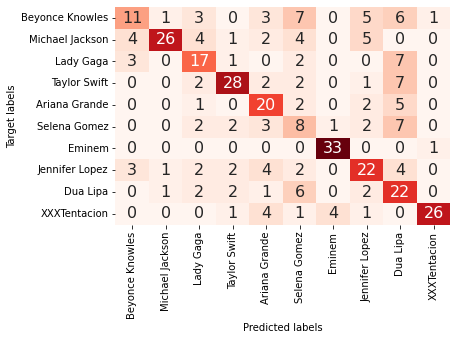

In [10]:
cm = confusion_matrix(t_label_ids, t_labels_predicted)
plotConfusionMatrix(cm, list(label2id.keys()) ,list(label2id.keys()))

### (B) Manually Examine the predictions

In [11]:
# Distil documents that is misclassified
def checkMissClassification(true_id, false_id, labels_test, labels_predicted):
    mistaken_docID = []
    for i in range(len(labels_test)):
        if(labels_test[i] == true_id and labels_predicted[i] == false_id):
            mistaken_docID.append(i)
    return mistaken_docID

#### Take a case where Lady Gaga's songs are labelled as "Dua Lipa"

In [28]:

mistaken_doc_id = checkMissClassification(label2id["Lady Gaga"],
                                           label2id["Dua Lipa"],
                                           t_label_ids, t_labels_predicted)
mistaken_doc_id

[10, 81, 126, 173, 197, 349, 352]

In [25]:
for mid in mistaken_doc_id:
    print('----------')
    print(texts_test[mid][:100])

----------
Quicksand
Quicksand Lyrics
I still see your coat hanging on the door
Never let anybody put one there
----------
Something Crazy
Something Crazy Lyrics
Wait, I think it's time
Your fire's lit and so is mine
Go tur
----------
Wish You Were Here
Wish You Were Here Lyrics
It's funny how things, they change
The clouds they part
----------
Enigma
Lyrics
Open-minded, I'm so blinded
Mystery man, woman phantom
Violet light smears the atmosph
----------
Bad Kids
Kids Lyrics
We don't care what people say, we know the truth
Enough is enough of this horse
----------
Second Time Around
Second Time Around Lyrics
Oh, oh yeah
Oh, baby

Last time I thought we had this t
----------
Love Me Right
Me Right Lyrics
Would you love me right?

My life is a story
Do you wanna know the tru


### Calculate Jaccard Similarity 

#### Identify the Document Id of Each Cluster

In [166]:
# For TP Lady Gaga
#name is given as TrueLabel_FalseLabel
Gaga_Gaga = checkMissClassification(label2id["Lady Gaga"], label2id["Lady Gaga"],t_label_ids, t_labels_predicted)
#TP DuaLipa
Dua_Dua = checkMissClassification(label2id["Dua Lipa"], label2id["Dua Lipa"],t_label_ids, t_labels_predicted)
#FP DuaLipa

Gaga_Dua = checkMissClassification(label2id["Lady Gaga"], label2id["Dua Lipa"],t_label_ids, t_labels_predicted)
Beyonce_Dua = checkMissClassification(label2id["Beyonce Knowles"], label2id["Dua Lipa"],t_label_ids, t_labels_predicted)
Tayor_Dua = checkMissClassification(label2id["Taylor Swift"], label2id["Dua Lipa"],t_label_ids, t_labels_predicted)
Ariana_Dua = checkMissClassification(label2id["Ariana Grande"], label2id["Dua Lipa"],t_label_ids, t_labels_predicted)
Selena_Dua = checkMissClassification(label2id["Selena Gomez"], label2id["Dua Lipa"],t_label_ids, t_labels_predicted)
Jennifer_Dua = checkMissClassification(label2id["Jennifer Lopez"], label2id["Dua Lipa"],t_label_ids, t_labels_predicted)


XXX_XXX = checkMissClassification(label2id["XXXTentacion"], label2id["XXXTentacion"],t_label_ids, t_labels_predicted)
Taylor_Taylor = checkMissClassification(label2id["Taylor Swift"], label2id["Taylor Swift"],t_label_ids, t_labels_predicted)
Ariana_Ariana = checkMissClassification(label2id["Ariana Grande"], label2id["Ariana Grande"],t_label_ids, t_labels_predicted)
Selena_Selena = checkMissClassification(label2id["Selena Gomez"], label2id["Selena Gomez"],t_label_ids, t_labels_predicted)
Jennifer_Jennifer = checkMissClassification(label2id["Jennifer Lopez"], label2id["Jennifer Lopez"],t_label_ids, t_labels_predicted)
DocIDs = [Gaga_Gaga, Dua_Dua,Gaga_Dua,Beyonce_Dua,Tayor_Dua,Ariana_Dua,Selena_Dua,Jennifer_Dua,
          XXX_XXX,Taylor_Taylor, Ariana_Ariana,Selena_Selena,Jennifer_Jennifer]

#### Fetch Texts and tokenize

In [167]:
import spacy
nlp = spacy.load("en_core_web_sm")

def text_pipeline_spacy(text):
  doc = nlp(text)
  lemmas = []
  for token in doc:
    if(token.is_punct or token.is_space): # punctuation and space is removed
      continue
    else:
      lemmas.append(token.lemma_.lower())
  return lemmas

In [170]:
target_keys = ["Gaga_Gaga", "Dua_Dua","Gaga_Dua","Beyonce_Dua","Taylor_Dua","Ariana_Dua","Selena_Dua","Jennifer_Dua","XXX_XXX",
               "Taylor_Taylor","Ariana_Ariana","Selena_Selena","Jennifer_Jennifer"]
target_texts = {}
for idx,docId in enumerate(DocIDs):
    lyrics = [[] for _ in range(len(docId))]
    for j,d in enumerate(docId):
        tokenized = text_pipeline_spacy(texts_test[d])
        lyrics[j] = tokenized
    target_texts[target_keys[idx]] = lyrics
        




In [171]:
# check the number of songs
len(target_texts["Gaga_Dua"])

7

### Compute Average Similarities

In [172]:
def sorenson_dice(tokens_X,tokens_Y):
  tokens_X = set(tokens_X)
  tokens_Y = set(tokens_Y)
  numerator = 2*len(tokens_X.intersection(tokens_Y))
  denominator = len(tokens_X) + len(tokens_Y)
  return numerator/denominator

In [173]:
def jaccard_similarity(tokens_X,tokens_Y):
  tokens_X = set(tokens_X)
  tokens_Y = set(tokens_Y)
  intersection = tokens_X.intersection(tokens_Y)
  union = tokens_X.union(tokens_Y)
  return len(intersection)/len(union)

def overlap_coefficient(tokens_X,tokens_Y):
  num_intersection = len(set(tokens_X).intersection(set(tokens_Y)))
  min_set_size = min(len(set(tokens_X)), len(set(tokens_Y)))
  return num_intersection/min_set_size
# Example usage:
# jaccard_similarity(['like','irn','bru','irn','bru'], ['irn','bru','very','bad'])
import numpy as np

def compute_average_similarity(doc_array1, doc_array2):
  similarities = []
  for d1 in doc_array1:
    for d2 in doc_array2:
      if d1 == d2:
        continue

      similarities.append(jaccard_similarity(d1,d2))
      # similarities.append(overlap_coefficient(d1,d2))
      # similarities.append(sorenson_dice(d1,d2))
  similarities = np.array(similarities)
  #return average, standard deviation, min, max
  return np.mean(similarities)#, np.std(similarities), np.min(similarities),np.max(similarities)


In [174]:
# check the function with Gaga_Gaga
compute_average_similarity(target_texts["Gaga_Gaga"],target_texts["Gaga_Gaga"])

0.15766372929457073

In [190]:
print("------False Negatives with True Labels-----")

print("Gaga_Dua   vs Gaga_Gaga",end=": ")
print(f'{compute_average_similarity(target_texts["Gaga_Dua"],target_texts["Gaga_Gaga"]):.3f}')
print("Taylor_Dua vs Taylor_Taylor",end=": ")
print(f'{compute_average_similarity(target_texts["Taylor_Dua"],target_texts["Taylor_Taylor"]):.3f}')
print("Ariana_Dua vs Ariana_Ariana",end=": ")
print(f'{compute_average_similarity(target_texts["Ariana_Dua"],target_texts["Ariana_Ariana"]):.3f}')
print("Selena_Dua vs Selena_Selena",end=": ")
print(f'{compute_average_similarity(target_texts["Selena_Dua"],target_texts["Selena_Selena"]):.3f}')
print("Jennifer_Dua vs Jennifer_Jennifer",end=": ")
print(f'{compute_average_similarity(target_texts["Jennifer_Dua"],target_texts["Jennifer_Jennifer"]):.3f}')



print("\n-----False Positives of Dua Lipa ---------")
print("Gaga_Dua   vs Dua_Dua",end="  : ")
print(f'{compute_average_similarity(target_texts["Gaga_Dua"],target_texts["Dua_Dua"]):.3f}')

print("Taylor_Dua vs Dua_Dua",end="  : ")
print(f'{compute_average_similarity(target_texts["Taylor_Dua"],target_texts["Dua_Dua"]):.3f}')
print("Ariana_Dua vs Dua_Dua",end="  : ")
print(f'{compute_average_similarity(target_texts["Ariana_Dua"],target_texts["Dua_Dua"]):.3f}')
print("Selena_Dua vs Dua_Dua",end="  : ")
print(f'{compute_average_similarity(target_texts["Selena_Dua"],target_texts["Dua_Dua"]):.3f}')
print("Jennifer_Dua vs Dua_Dua",end=": ")
print(f'{compute_average_similarity(target_texts["Jennifer_Dua"],target_texts["Dua_Dua"]):.3f}')


print("\n----True Positives against themselves--------")
print("Dua_Dua    vs Dua_Dua",end="  : ")
print(f'{compute_average_similarity(target_texts["Dua_Dua"],target_texts["Dua_Dua"]):.3f}')
print("Gaga_Gaga  vs Gaga_Gaga",end=": ")
print(f'{compute_average_similarity(target_texts["Gaga_Gaga"],target_texts["Gaga_Gaga"]):.3f}')
print("Taylor_Taylor vs Taylor_Taylor",end=": ")
print(f'{compute_average_similarity(target_texts["Taylor_Taylor"],target_texts["Taylor_Taylor"]):.3f}')
print("Ariana_Ariana vs Ariana_Ariana",end=": ")
print(f'{compute_average_similarity(target_texts["Ariana_Ariana"],target_texts["Ariana_Ariana"]):.3f}')
print("Selena_Selena  vs Selena_Selena",end=": ")
print(f'{compute_average_similarity(target_texts["Selena_Selena"],target_texts["Selena_Selena"]):.3f}')
print("Jennifer_Jennifer  vs Jennifer_Jennifer",end=": ")
print(f'{compute_average_similarity(target_texts["Jennifer_Jennifer"],target_texts["Jennifer_Jennifer"]):.3f}')
print("XXX_XXX    vs XXX_XXX",end=": ")
print(f'{compute_average_similarity(target_texts["XXX_XXX"],target_texts["XXX_XXX"]):.3f}')

print("\n----True Positives against other True Positives")
print("Gaga_Gaga vs Dua_Dua",end=": ")
print(f'{compute_average_similarity(target_texts["Gaga_Gaga"],target_texts["Dua_Dua"]):.3f}')
print("Taylor_Taylor vs Dua_Dua",end=": ")
print(f'{compute_average_similarity(target_texts["Taylor_Taylor"],target_texts["Dua_Dua"]):.3f}')
print("Ariana_Ariana vs Dua_Dua",end=": ")
print(f'{compute_average_similarity(target_texts["Ariana_Ariana"],target_texts["Dua_Dua"]):.3f}')
print("Selena_Selena vs Dua_Dua",end=": ")
print(f'{compute_average_similarity(target_texts["Selena_Selena"],target_texts["Dua_Dua"]):.3f}')
print("Jennifer_Jennifer vs Dua_Dua",end=": ")
print(f'{compute_average_similarity(target_texts["Jennifer_Jennifer"],target_texts["Dua_Dua"]):.3f}')

------False Negatives with True Labels-----
Gaga_Dua   vs Gaga_Gaga: 0.174
Taylor_Dua vs Taylor_Taylor: 0.209
Ariana_Dua vs Ariana_Ariana: 0.199
Selena_Dua vs Selena_Selena: 0.154
Jennifer_Dua vs Jennifer_Jennifer: 0.188

-----False Positives of Dua Lipa ---------
Gaga_Dua   vs Dua_Dua  : 0.205
Taylor_Dua vs Dua_Dua  : 0.203
Ariana_Dua vs Dua_Dua  : 0.206
Selena_Dua vs Dua_Dua  : 0.194
Jennifer_Dua vs Dua_Dua: 0.208

----True Positives against themselves--------
Dua_Dua    vs Dua_Dua  : 0.196
Gaga_Gaga  vs Gaga_Gaga: 0.158
Taylor_Taylor vs Taylor_Taylor: 0.207
Ariana_Ariana vs Ariana_Ariana: 0.179
Selena_Selena  vs Selena_Selena: 0.116
Jennifer_Jennifer  vs Jennifer_Jennifer: 0.164
XXX_XXX    vs XXX_XXX: 0.128

----True Positives against other True Positives
Gaga_Gaga vs Dua_Dua: 0.164
Taylor_Taylor vs Dua_Dua: 0.195
Ariana_Ariana vs Dua_Dua: 0.183
Selena_Selena vs Dua_Dua: 0.148
Jennifer_Jennifer vs Dua_Dua: 0.169


In [177]:
print("---------Gaga with others-------")
# print("Gaga_Dua   vs Gaga_Gaga",end=": ")
# print(f'{compute_average_similarity(target_texts["Gaga_Dua"],target_texts["Gaga_Gaga"]):.3f}')
# print("Dua_Dua    vs Gaga_Gaga",end=": ")
# print(f'{compute_average_similarity(target_texts["Dua_Dua"],target_texts["Gaga_Gaga"]):.3f}')


# print("\n----------- False Positive of Dua Lipa ---------")
# print("Gaga_Dua   vs Dua_Dua",end="  : ")
# print(f'{compute_average_similarity(target_texts["Gaga_Dua"],target_texts["Dua_Dua"]):.3f}')

# print("Taylor_Dua vs Dua_Dua",end="  : ")
# print(f'{compute_average_similarity(target_texts["Taylor_Dua"],target_texts["Dua_Dua"]):.3f}')
# print("Ariana_Dua vs Dua_Dua",end="  : ")
# print(f'{compute_average_similarity(target_texts["Ariana_Dua"],target_texts["Dua_Dua"]):.3f}')
# print("Selena_Dua vs Dua_Dua",end="  : ")
# print(f'{compute_average_similarity(target_texts["Selena_Dua"],target_texts["Dua_Dua"]):.3f}')
# print("Jennifer_Dua vs Dua_Dua",end=": ")
# print(f'{compute_average_similarity(target_texts["Jennifer_Dua"],target_texts["Dua_Dua"]):.3f}')

# print("\n-------- With themselves for TP --------")
# print("Dua_Dua    vs Dua_Dua",end="  : ")
# print(f'{compute_average_similarity(target_texts["Dua_Dua"],target_texts["Dua_Dua"]):.3f}')
# print("Gaga_Gaga  vs Gaga_Gaga",end=": ")
# print(f'{compute_average_similarity(target_texts["Gaga_Gaga"],target_texts["Gaga_Gaga"]):.3f}')
# print("Taylor_Taylor vs Taylor_Taylor",end=": ")
# print(f'{compute_average_similarity(target_texts["Taylor_Taylor"],target_texts["Taylor_Taylor"]):.3f}')
# print("Ariana_Ariana vs Ariana_Ariana",end=": ")
# print(f'{compute_average_similarity(target_texts["Ariana_Ariana"],target_texts["Ariana_Ariana"]):.3f}')
# print("Selena_Selena  vs Selena_Selena",end=": ")
# print(f'{compute_average_similarity(target_texts["Selena_Selena"],target_texts["Selena_Selena"]):.3f}')
# print("Jennifer_Jennifer  vs Jennifer_Jennifer",end=": ")
# print(f'{compute_average_similarity(target_texts["Jennifer_Jennifer"],target_texts["Jennifer_Jennifer"]):.3f}')
# print("XXX_XXX    vs XXX_XXX",end=": ")
# print(f'{compute_average_similarity(target_texts["XXX_XXX"],target_texts["XXX_XXX"]):.3f}')

# print("\n-------- With themselves for FP for Dua Lipa--------")
# print("Gaga_Dua    vs Gaga_Dua",end="  : ")
# print(f'{compute_average_similarity(target_texts["Gaga_Dua"],target_texts["Gaga_Dua"]):.3f}')
# print("Taylor_Dua  vs Taylor_Dua",end=": ")
# print(f'{compute_average_similarity(target_texts["Taylor_Dua"],target_texts["Taylor_Dua"]):.3f}')
# print("XXX_XXX    vs XXX_XXX",end="  : ")
# print(f'{compute_average_similarity(target_texts["XXX_XXX"],target_texts["XXX_XXX"]):.3f}')

print("\n------- XXX with others--------")
print("XXX_XXX    vs Dua_Dua",end="  : ")
print(f'{compute_average_similarity(target_texts["XXX_XXX"],target_texts["Dua_Dua"]):.3f}')
print("XXX_XXX    vs Gaga_Gaga",end=": ")
print(f'{compute_average_similarity(target_texts["XXX_XXX"],target_texts["Gaga_Gaga"]):.3f}')


# for doc1 in target_texts.values():
#     # print(doc1)
#     print(len(doc1))
#     for doc2 in target_texts.values():
#         print(compute_average_similarity(doc1,doc2)) #

---------Gaga with others-------
Gaga_Dua   vs Gaga_Gaga: 0.174
Dua_Dua    vs Gaga_Gaga: 0.164

----------- False Positive of Dua Lipa ---------
Gaga_Dua   vs Dua_Dua  : 0.205
Taylor_Dua vs Dua_Dua  : 0.203
Ariana_Dua vs Dua_Dua  : 0.206
Selena_Dua vs Dua_Dua  : 0.194
Jennifer_Dua vs Dua_Dua: 0.208

-------- With themselves for TP --------
Dua_Dua    vs Dua_Dua  : 0.196
Gaga_Gaga  vs Gaga_Gaga: 0.158
Taylor_Taylor vs Taylor_Taylor: 0.207
Ariana_Ariana vs Ariana_Ariana: 0.179
Selena_Selena  vs Selena_Selena: 0.116
Jennifer_Jennifer  vs Jennifer_Jennifer: 0.164
XXX_XXX    vs XXX_XXX: 0.128

------- XXX with others--------
XXX_XXX    vs Dua_Dua  : 0.145
XXX_XXX    vs Gaga_Gaga: 0.130


# ここから下はゴミ

## Tune Parameters

In [10]:
# 3 sets of parameters
# Batch size cannot be over 16 due to memory issue.

# make model sensitive to each data by decreasing batch_size and increasing learning_rate
param_a = {"learning_rate":1e-3,
           "epochs": 10,
           "batch_size":4}

# make model less sensitive to each data by increasing batch_size and decreasing learning_rate. increase epochs instead to help converge.
param_b = {"learning_rate":1e-5,
           "epochs":50 ,
           "batch_size":16}

# middle of A and B
param_c = {"learning_rate":1e-4,
           "epochs": 25,
           "batch_size":8}
params = [param_a,param_b, param_c]


In [11]:
from transformers import TrainingArguments, Trainer,DataCollatorWithPadding

def tuneParams(p,name):
  # for idx,p in enumerate(params):
    # configuring parameters
  training_args = TrainingArguments(
      output_dir                 = f"model_{name}", # HuggingFace wants a name for your model
      evaluation_strategy        = "epoch", # How often we want to evaluate the model
      learning_rate              = p["learning_rate"], # Hyperparameter
      per_device_train_batch_size= p["batch_size"], # Hyperparameter
      per_device_eval_batch_size = p["batch_size"], # Hyperparameter
      num_train_epochs           = p["epochs"] # Hyperparameter
      # weight_decay=weight_decay, # Hyperparameter
  )
    
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    # training
  trainer = Trainer(
      model=model, # The model you want to train
      args=training_args, # The various training arguments set up above
      train_dataset=train_dataset, # The data to use to update the weights
      eval_dataset=validation_dataset, # The data to use 
      tokenizer=tokenizer, # The tokenizer used on the data
      data_collator=data_collator, # A data collator that does clever things moving data around
      )
    
  trainer.train()

  # measuring metrics with validation set
  predictions, label_ids, metrics = trainer.predict(validation_dataset)
  labels_predicted = predictions.argmax(axis=1)
  print(f'----------model{name}---------')
  showPerformance(label_ids, labels_predicted)
  print("\n")
  return ;

# あとで消す
# Show classifier performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def showPerformance(labels_true, labels_predicted):
    print(f'accuracy ={accuracy_score(labels_true, labels_predicted):.3f}')
    print(f'precision={precision_score(labels_true, labels_predicted, average="macro"):.3f}')
    print(f'recall   ={recall_score(labels_true, labels_predicted, average="macro"):.3f}') 
    print(f'f1       ={f1_score(labels_true, labels_predicted, average="macro"):.3f}')
    return ;


In [ ]:
tuneParams(params[0],'a')

In [ ]:
tuneParams(params[1],'b')

In [ ]:
tuneParams(params[2],'c')

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1070
  Num Epochs = 25
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3350
  Number of trainable parameters = 124653322
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,No log,2.328768
2,No log,2.305428
3,No log,2.309634
4,2.306400,2.309653
5,2.306400,2.303613
6,2.306400,2.304098
7,2.306400,2.313816
8,2.298600,2.315737
9,2.298600,2.310245
10,2.298600,2.305802


***** Running Evaluation *****
  Num examples = 357
  Batch size = 8
***** Running Evaluation *****
  Num examples = 357
  Batch size = 8
***** Running Evaluation *****
  Num examples = 357
  Batch size = 8
Saving model checkpoint to model_c/checkpoint-500
Configuration saved in model_c/checkpoint-500/config.json
Model weights saved in model_c/checkpoint-500/pytorch_model.bin
tokenizer config file saved in model_c/checkpoint-500/tokenizer_config.json
Special tokens file saved in model_c/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 357
  Batch size = 8
***** Running Evaluation *****
  Num examples = 357
  Batch size = 8
***** Running Evaluation *****
  Num examples = 357
  Batch size = 8
***** Running Evaluation *****
  Num examples = 357
  Batch size = 8
Saving model checkpoint to model_c/checkpoint-1000
Configuration saved in model_c/checkpoint-1000/config.json
Model weights saved in model_c/checkpoint-1000/pytorch_model.bin
tokenizer config f

### rubbish



In [ ]:

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


trainer = Trainer(
    model=model, # The model you want to train
    args=training_args, # The various training arguments set up above
    train_dataset=train_dataset, # The data to use to update the weights
    eval_dataset=validation_dataset, # The data to use 
    tokenizer=tokenizer, # The tokenizer used on the data
    data_collator=data_collator, # A data collator that does clever things moving data around
)
trainer.train()
predictions, label_ids, metrics = trainer.predict(validation_dataset)


***** Running training *****
  Num examples = 1070
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 670
  Number of trainable parameters = 124653322


Epoch,Training Loss,Validation Loss
1,No log,2.120549
2,No log,2.319053
3,No log,2.318110
4,No log,2.307925
5,No log,2.301143
6,No log,2.288367
7,No log,2.296800
8,2.252600,2.318459
9,2.252600,2.301956
10,2.252600,2.301772


***** Running Evaluation *****
  Num examples = 357
  Batch size = 16
***** Running Evaluation *****
  Num examples = 357
  Batch size = 16
***** Running Evaluation *****
  Num examples = 357
  Batch size = 16
***** Running Evaluation *****
  Num examples = 357
  Batch size = 16
***** Running Evaluation *****
  Num examples = 357
  Batch size = 16
***** Running Evaluation *****
  Num examples = 357
  Batch size = 16
***** Running Evaluation *****
  Num examples = 357
  Batch size = 16
Saving model checkpoint to singers_model/checkpoint-500
Configuration saved in singers_model/checkpoint-500/config.json
Model weights saved in singers_model/checkpoint-500/pytorch_model.bin
tokenizer config file saved in singers_model/checkpoint-500/tokenizer_config.json
Special tokens file saved in singers_model/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 357
  Batch size = 16
***** Running Evaluation *****
  Num examples = 357
  Batch size = 16
***** Running Ev

In [ ]:
labels_predicted = predictions.argmax(axis=1)
showPerformance(label_ids, labels_predicted)

accuracy =0.084
precision=0.008
recall   =0.100
f1       =0.016


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ここから下は適当に打ち込んでいる

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

#### Create dataset

In [ ]:
# correspond labels(songer names) with integers
label2id = {label: i for i, label in enumerate(labels.)}

In [ ]:
from transformers import set_seed, AutoModelForSequenceClassification

set_seed(42)

model = AutoModelForSequenceClassification.from_pretrained('roberta-base')

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/pytorch_

In [ ]:
# parameters
learning_rate = 1e-4
epochs = 1
batch_size = 16
weight_decay = None


In [ ]:
from datasets import Dataset
import numpy as np

# labels_train = np.random.randint(0,9,1070)
# labels_val = np.random.randint(0,9,357)

train_dataset = Dataset.from_dict({
    "input_ids":np.array(texts_train),
    "labels":np.array(labels_train)})
validation_dataset = Dataset.from_dict({
    "input_ids":np.array(texts_val), 
    "labels":np.array(labels_val)})
train_dataset[0]

{'input_ids': "Perfect Illusion\nPerfect Illusion Lyrics\nTryin' to get control\nPressure's takin' its toll\nStuck in the middle zone\nI just want you alone\nMy guessing game is strong\nWay too real to be wrong\nCaught up in your show\nYeah, at least now I know\n\nIt wasn't love, it wasn't love\nIt was a perfect illusion (Perfect illusion)\nMistaken for love, it wasn't love\nIt was a perfect illusion (Perfect illusion)\nYou were a perfect illusion\nI don't need eyes to see\nI felt you touchin' me\nHigh like amphetamine\nMaybe you're just a dream\nThat's what it means to crush\nNow that I'm wakin' up\nI still feel the blow\nBut at least now I know\n\nIt wasn't love, it wasn't love\nIt was a perfect illusion (Perfect illusion)\nMistaken for love, it wasn't love\nIt was a perfect illusion (Perfect illusion)\n\nWhere are you?\n'Cause I can't see you\nIt was a perfect illusion\nBut I feel you watchin' me\nDilated, falling free\nIn a modern ecstasy\nWhere are you?\n'Cause I can't see you\nIt

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="singers_model", # HuggingFace wants a name for your model
    evaluation_strategy="epoch", # How often we want to evaluate the model
    learning_rate=learning_rate, # Hyperparameter
    per_device_train_batch_size=batch_size, # Hyperparameter
    per_device_eval_batch_size=batch_size, # Hyperparameter
    num_train_epochs=epochs, # Hyperparameter
    weight_decay=weight_decay, # Hyperparameter
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
#from transformers import DataCollatorForTokenClassification

#data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


trainer = Trainer(
    model=model, # The model you want to train
    args=training_args, # The various training arguments set up above
    train_dataset=train_dataset, # The data to use to update the weights
    eval_dataset=validation_dataset, # The data to use 
    tokenizer=tokenizer, # The tokenizer used on the data
    data_collator=data_collator, # A data collator that does clever things moving data around
)

In [ ]:
train_dataset[18]["input_ids"][:100]
# for t in train_dataset:
  # print(type(t["input_ids"]))

'Why Don’t You Love Me\nWhy Don’t You Love Me Lyrics\nNow, now, now, honey\nYou better sit down and look'

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 1070
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 67
  Number of trainable parameters = 124647170


ValueError: ignored

In [ ]:
predictions, label_ids, metrics = trainer.predict(validation_dataset)

In [ ]:
metrics

NameError: ignored

In [ ]:
print(f"{type(predictions)=}")
print(f"{predictions.shape=}")